Inspired By:\
https://github.com/JRC1995/Bi-GRU-CRF-NER

https://www.kaggle.com/code/samarthsarin/keras-gru-with-glove-embedding/notebook

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install tf2crf

In [ ]:
!pip install sklearn_crfsuite

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
class SentenceGetter(object):
    
    def __init__(self, filenames_list):
        self.sentences = []
        self.words = set()
        self.tags = set()
        for filename in filenames_list:
          with open(filename) as f:
              sentence = []
              for line in f:
                  line = line.strip()
                  if (len(line) == 0 or line.startswith("-DOCSTART-") or line.startswith("......")):
                      if len(sentence) != 0:
                        self.sentences.append(sentence)
                        sentence = []
                      continue
                  else:
                      ls = line.split(' ')
                      word, tag = ls[0],ls[3]
                      self.words.add(word)
                      self.tags.add(tag)
                      sentence.append((word,tag))

In [ ]:
#MCHP_dataset_1
files = ['/content/drive/MyDrive/MasterThesis/NER/MCHP/dataset_1/cn569258-pin.conll', '/content/drive/MyDrive/MasterThesis/NER/MCHP/dataset_2/project-13-at-2022-06-14-08-59-1d16c7ec.conll'] #Shreya
getter = SentenceGetter(files)
sentences = getter.sentences
words = getter.words
tags = list(getter.tags)

In [ ]:
words = list(words) #set to list convert

In [ ]:
len(sentences)

545

In [ ]:
len(words)

10007

In [ ]:
#ADD PAD to words
words.append('PAD')

In [ ]:
tags

['I-Pin', 'B-Pin', 'O']

In [ ]:
tags.insert(0,'PAD')

In [ ]:
n_words = len(words)
n_tags = len(tags)

In [ ]:
n_words, n_tags

(10008, 4)

In [ ]:
tags

['PAD', 'I-Pin', 'B-Pin', 'O']

In [ ]:
from tqdm import tqdm

In [ ]:
embedding_vector = {}
f = open('/content/drive/MyDrive/MasterThesis/Glove/glove.6B.100d.txt') 
for line in tqdm(f):
    vector = line.split(' ')
    word = vector[0]
    coef = np.asarray(vector[1:],dtype = 'float32')
    embedding_vector[word]=coef
f.close()
print('Number of words found ',len(embedding_vector))

400000it [00:14, 28377.93it/s]

Number of words found  400000


In [ ]:
from keras.preprocessing.text import Tokenizer

In [ ]:
token = Tokenizer()
token.fit_on_texts(words)

In [ ]:
sequence = token.texts_to_sequences(words)

In [ ]:
vocab_size = len(token.word_index)+1

In [ ]:
vocab_size

4962

In [ ]:
embedding_matrix = np.zeros((vocab_size,100))
for word,i in tqdm(token.word_index.items()):
    embedding_vectors = embedding_vector.get(word)
    if embedding_vectors is not None:
        embedding_matrix[i] = embedding_vector[word]

100%|██████████| 4961/4961 [00:00<00:00, 411916.11it/s]


In [ ]:
from future.utils import iteritems

tag2idx = {t: i for i, t in enumerate(tags)}

idx2tag = {v: k for k, v in iteritems(tag2idx)}

In [ ]:
tag2idx

{'PAD': 0, 'I-Pin': 1, 'B-Pin': 2, 'O': 3}

In [ ]:
#Feature and Label separation
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

maxlen = max([len(s) for s in sentences])

total_feature = [[token.word_index.get(w[0].lower()) for w in s if w[0].lower() in token.word_index] for s in sentences]
X = pad_sequences(maxlen=maxlen, sequences=total_feature, dtype='int32', padding="post", value=token.word_index.get('pad')) #embedding_matrix 0 position is blank value
total_label = [[tag2idx[w[1]] for w in s if w[0].lower() in token.word_index] for s in sentences]
y_label = pad_sequences(maxlen=maxlen, sequences=total_label, dtype='int32', padding="post", value=tag2idx["PAD"])

Y = [to_categorical(i, num_classes=n_tags) for i in y_label]

In [ ]:
print(
        'X_tokens length:', len(X),
        '\nY_tags:', len(Y)
    )

X_tokens length: 545 
Y_tags: 545


In [ ]:
sentences[0]

[('Appendix', 'O'),
 ('D:', 'O'),
 ('List', 'O'),
 ('of', 'O'),
 ('Tables', 'O'),
 ('Table', 'O'),
 ('2-1:', 'O'),
 ('Pinout', 'O'),
 ('List', 'O')]

In [ ]:
for token_id, tag in zip(X[0], Y[0]):
    print('%s\t%s' % (token_id, tag))

In [ ]:
#devide the data into train test valid
#choosing 70, 20, 10 ratio

from sklearn.model_selection import train_test_split
X_data, X_test, Y_data, y_test = train_test_split(X,Y,test_size=0.20,shuffle=True, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_data,Y_data,test_size=0.10,shuffle=True, random_state=42)


print(
        '\X_tokens length:', len(X),
        '\ntrain_tokens length:', len(X_train),
        '\nval_tokens length:', len(X_val),
        '\ntest_tokens length:', len(X_test),
        '\n\nY_tags length:', len(Y),
        '\ntrain_tags:', len(y_train),
        '\nval_tags:', len(y_val),
        '\ntest_tags:', len(y_test)
    )

\X_tokens length: 545 
train_tokens length: 392 
val_tokens length: 44 
test_tokens length: 109 

Y_tags length: 545 
train_tags: 392 
val_tags: 44 
test_tags: 109


In [ ]:
np.array(y_test).shape

(109, 762, 4)

#Model

In [ ]:
import tensorflow

In [ ]:
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

In [ ]:
input_dim = vocab_size
input_length = maxlen
n_tags = len(tag2idx)
print('input_dim: ', input_dim, '\ninput_length: ', input_length, '\nn_tags: ', n_tags)

input_dim:  4962 
input_length:  762 
n_tags:  4


In [ ]:
import numpy as np
import tensorflow.keras as kk
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import GRU, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model
from tf2crf import CRF, ModelWithCRFLoss

In [ ]:
word_embedding_size = 100
units_size = 50

#input layer
input = Input(shape=(maxlen,))

# Embedding Layer
embed = Embedding(input_dim=input_dim, output_dim=word_embedding_size, weights = [embedding_matrix], input_length =maxlen, mask_zero=True, trainable = False)(input)

# BI-LSTM Layer
model = Bidirectional(GRU(units=units_size, 
                           return_sequences=True, 
                           dropout=0.5, 
                           recurrent_dropout=0.5, 
                           kernel_initializer=kk.initializers.he_normal()))(embed)

# TimeDistributed Layer
model = TimeDistributed(Dense(units_size, activation="relu"))(model) 

# CRF Layer
crf = CRF(units=n_tags)

output = crf(model)

base_model = Model(input, output)

base_model.summary()

model = ModelWithCRFLoss(base_model, sparse_target=False)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 762)]             0         
                                                                 
 embedding (Embedding)       (None, 762, 100)          496200    
                                                                 
 bidirectional (Bidirectiona  (None, 762, 100)         45600     
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 762, 50)          5050      
 ibuted)                                                         
                                                                 
 crf (CRF)                   ((None, 762),             220       
                              (None, 762, 4),                    
                              (None,),                       

In [ ]:
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

#Optimiser 
# adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

# Compile model
# model.compile(optimizer=adam)
model.compile(optimizer="rmsprop")



# Saving the best model only
filepath="ner-bi-GRU-tf2crf-model-ds-{accuracy:.2f}.tf"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(X_train, np.array(y_train), validation_data = (X_val, np.array(y_val)), batch_size=32, epochs=15, verbose=1, callbacks=callbacks_list)

Epoch 1/15
13/13 [==============================] - ETA: 0s - loss: 395.4001 - accuracy: 0.8042
Epoch 1: accuracy improved from -inf to 0.80424, saving model to ner-bi-GRU-tf2crf-model-ds-0.80.tf


13/13 [==============================] - 71s 5s/step - loss: 395.4001 - accuracy: 0.8042 - val_loss_val: 131.2537 - val_val_accuracy: 0.9385
Epoch 2/15
13/13 [==============================] - ETA: 0s - loss: 64.3897 - accuracy: 0.9804
Epoch 2: accuracy improved from 0.80424 to 0.98039, saving model to ner-bi-GRU-tf2crf-model-ds-0.98.tf


13/13 [==============================] - 54s 4s/step - loss: 64.3897 - accuracy: 0.9804 - val_loss_val: 33.8281 - val_val_accuracy: 0.9940
Epoch 3/15
13/13 [==============================] - ETA: 0s - loss: 22.4347 - accuracy: 0.9960
Epoch 3: accuracy improved from 0.98039 to 0.99597, saving model to ner-bi-GRU-tf2crf-model-ds-1.00.tf


13/13 [==============================] - 53s 4s/step - loss: 22.4347 - accuracy: 0.9960 - val_loss_val: 17.0474 - val_val_accuracy: 0.9963
Epoch 4/15
13/13 [==============================] - ETA: 0s - loss: 13.3412 - accuracy: 0.9968
Epoch 4: accuracy improved from 0.99597 to 0.99679, saving model to ner-bi-GRU-tf2crf-model-ds-1.00.tf


13/13 [==============================] - 55s 4s/step - loss: 13.3412 - accuracy: 0.9968 - val_loss_val: 12.9425 - val_val_accuracy: 0.9965
Epoch 5/15
13/13 [==============================] - ETA: 0s - loss: 10.8255 - accuracy: 0.9971
Epoch 5: accuracy improved from 0.99679 to 0.99713, saving model to ner-bi-GRU-tf2crf-model-ds-1.00.tf


13/13 [==============================] - 56s 4s/step - loss: 10.8255 - accuracy: 0.9971 - val_loss_val: 9.8301 - val_val_accuracy: 0.9966
Epoch 6/15
13/13 [==============================] - ETA: 0s - loss: 9.0904 - accuracy: 0.9973
Epoch 6: accuracy improved from 0.99713 to 0.99735, saving model to ner-bi-GRU-tf2crf-model-ds-1.00.tf


13/13 [==============================] - 57s 4s/step - loss: 9.0904 - accuracy: 0.9973 - val_loss_val: 8.3405 - val_val_accuracy: 0.9969
Epoch 7/15
13/13 [==============================] - ETA: 0s - loss: 8.0459 - accuracy: 0.9974
Epoch 7: accuracy improved from 0.99735 to 0.99741, saving model to ner-bi-GRU-tf2crf-model-ds-1.00.tf


13/13 [==============================] - 54s 4s/step - loss: 8.0459 - accuracy: 0.9974 - val_loss_val: 7.4182 - val_val_accuracy: 0.9971
Epoch 8/15
13/13 [==============================] - ETA: 0s - loss: 6.8781 - accuracy: 0.9976
Epoch 8: accuracy improved from 0.99741 to 0.99758, saving model to ner-bi-GRU-tf2crf-model-ds-1.00.tf


13/13 [==============================] - 53s 4s/step - loss: 6.8781 - accuracy: 0.9976 - val_loss_val: 6.1800 - val_val_accuracy: 0.9971
Epoch 9/15
13/13 [==============================] - ETA: 0s - loss: 6.0612 - accuracy: 0.9976
Epoch 9: accuracy did not improve from 0.99758
13/13 [==============================] - 35s 3s/step - loss: 6.0612 - accuracy: 0.9976 - val_loss_val: 5.6672 - val_val_accuracy: 0.9973
Epoch 10/15
13/13 [==============================] - ETA: 0s - loss: 6.0662 - accuracy: 0.9978
Epoch 10: accuracy improved from 0.99758 to 0.99777, saving model to ner-bi-GRU-tf2crf-model-ds-1.00.tf


13/13 [==============================] - 53s 4s/step - loss: 6.0662 - accuracy: 0.9978 - val_loss_val: 5.1651 - val_val_accuracy: 0.9975
Epoch 11/15
13/13 [==============================] - ETA: 0s - loss: 5.5916 - accuracy: 0.9978
Epoch 11: accuracy improved from 0.99777 to 0.99781, saving model to ner-bi-GRU-tf2crf-model-ds-1.00.tf


13/13 [==============================] - 55s 4s/step - loss: 5.5916 - accuracy: 0.9978 - val_loss_val: 5.1973 - val_val_accuracy: 0.9980
Epoch 12/15
13/13 [==============================] - ETA: 0s - loss: 5.0256 - accuracy: 0.9980
Epoch 12: accuracy improved from 0.99781 to 0.99798, saving model to ner-bi-GRU-tf2crf-model-ds-1.00.tf


13/13 [==============================] - 55s 4s/step - loss: 5.0256 - accuracy: 0.9980 - val_loss_val: 4.6976 - val_val_accuracy: 0.9980
Epoch 13/15
13/13 [==============================] - ETA: 0s - loss: 4.9227 - accuracy: 0.9981
Epoch 13: accuracy improved from 0.99798 to 0.99808, saving model to ner-bi-GRU-tf2crf-model-ds-1.00.tf


13/13 [==============================] - 53s 4s/step - loss: 4.9227 - accuracy: 0.9981 - val_loss_val: 6.8679 - val_val_accuracy: 0.9976
Epoch 14/15
13/13 [==============================] - ETA: 0s - loss: 4.6938 - accuracy: 0.9981
Epoch 14: accuracy improved from 0.99808 to 0.99810, saving model to ner-bi-GRU-tf2crf-model-ds-1.00.tf


13/13 [==============================] - 55s 4s/step - loss: 4.6938 - accuracy: 0.9981 - val_loss_val: 4.2623 - val_val_accuracy: 0.9981
Epoch 15/15
13/13 [==============================] - ETA: 0s - loss: 4.6474 - accuracy: 0.9981
Epoch 15: accuracy improved from 0.99810 to 0.99815, saving model to ner-bi-GRU-tf2crf-model-ds-1.00.tf


13/13 [==============================] - 53s 4s/step - loss: 4.6474 - accuracy: 0.9981 - val_loss_val: 4.7543 - val_val_accuracy: 0.9982


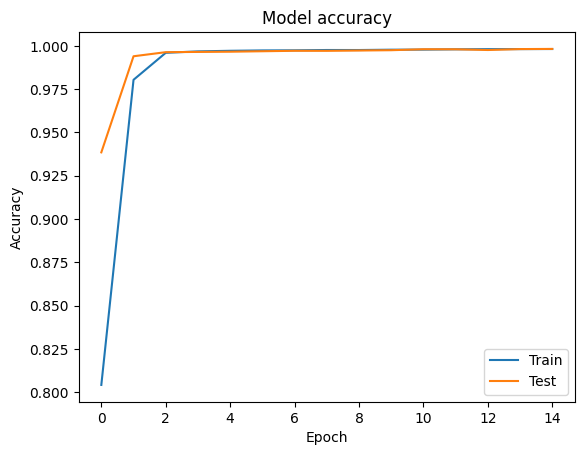

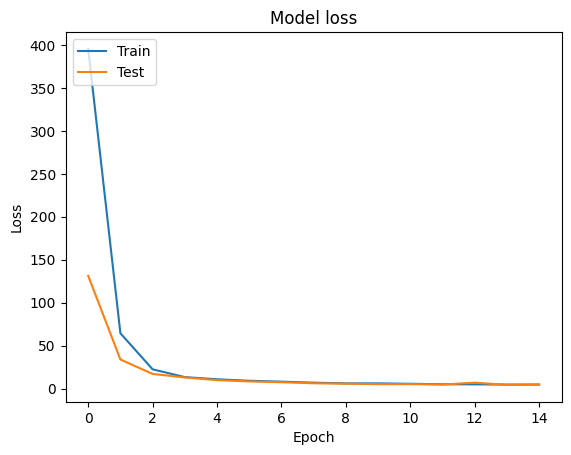

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss_val'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Prediction
pred_cat = model.predict(X_test, verbose=1)
y_te_true = np.argmax(y_test, -1)

4/4 [==============================] - 4s 554ms/step


In [ ]:
#New classification report
from sklearn_crfsuite.utils import flatten
from functools import wraps


def _flattens_y(func):
    @wraps(func)
    def wrapper(y_true, y_pred, *args, **kwargs):
        y_true_flat = flatten(y_true)
        y_pred_flat = flatten(y_pred)
        return func(y_true_flat, y_pred_flat, *args, **kwargs)
    return wrapper


@_flattens_y
def flat_classification_report(y_true, y_pred, labels=None, target_names=None, **kwargs):
    """
    Return classification report for sequence items.
    """
    from sklearn import metrics
    return metrics.classification_report(y_true, y_pred, labels=labels, target_names=target_names, **kwargs)

In [ ]:
#Flat Classification report 
report = flat_classification_report(y_te_true, pred_cat) #imbalance data, test data doesnot have all the classes
# report = flat_classification_report(y_te_true, pred_cat, target_names=tags)
report_edited = report.replace(" 0 ", " "+idx2tag[0]+"  ").replace(" 1 ", " "+idx2tag[1]+"   ").replace(" 2 ", " "+idx2tag[2]+"").replace(" 3 ", " "+idx2tag[3]+"    ")
print(report_edited)

              precision    recall  f1-score   support

           PAD        1.00      1.00      1.00     67429
           B-Pin      0.57      0.54      0.56       197
           O          0.99      0.99      0.99     15432

    accuracy                           1.00     83058
   macro avg       0.85      0.85      0.85     83058
weighted avg       1.00      1.00      1.00     83058



In [ ]:
i = np.random.randint(0,X_test.shape[0]) # choose a random number between 0 and len(X_te)
p = model.predict(np.array([X_test[i]]))
# p = np.argmax(p, axis=-1)
true = np.argmax(y_test[i], -1)

print("Sample number {} of {} (Test Set)".format(i, X_test.shape[0]))
# Visualization
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_test[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-2], idx2tag[t], idx2tag[pred]))

1/1 [==============================] - 2s 2s/step
Sample number 37 of 109 (Test Set)
Word           ||True ||Pred
0x400          : O     O
(PWROFF_HT)).  : O     O
advantage      : O     O
(defined       : O     O
clean,         : O     O
Edge           : O     O
LIN),          : O     O
power-up.      : O     O
locally        : O     O
ignored        : O     O
Head           : O     O
0x400          : O     O
integrate      : O     O
operation.     : O     O
(SR.SV         : O     O
Edge           : O     O
suitable       : O     O
video          : O     O
01             : O     O
constrained    : O     O
kbytes         : O     O
Appendix       : O     O
Head           : O     O
effect         : O     O
Evaluation     : O     O
0x400          : O     O
telephone      : O     O
eam            : O     O
pre-programmed : O     O
(edge          : O     O
browser        : O     O
Blocks,        : O     O
1-1.           : O     O
(defined       : O     O
(SR.SV         : O     O
Get        